# Import Library

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.decomposition import PCA

In [2]:
# read train data and test data from directory
# dir_dataset = "E:\ilmu\Kuliah\sem 7 dan 8\Tugas Akhir\dataset\\Network Attack Simulation\Dataset of DoS Attack Simulation"
dir_dataset = 'TRAIN DATA AND TEST DATA DIRECTORY'

df_train = pd.read_csv(dir_dataset + '\\train.csv')
df_test = pd.read_csv(dir_dataset + '\\test.csv')

In [3]:
#  load dataset into train data, train labels, test data and test labels
def load_train_test(df_train, df_test):
    train_x, train_y = df_train.iloc[:, :-1], df_train.iloc[:, -1]
    test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]
    return train_x, train_y, test_x, test_y

In [4]:
# call function load_train_test()
train_x, train_y, test_x, test_y = load_train_test(df_train, df_test)

In [5]:
# scaling train data and test data
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
# construct random forest classifier
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)

In [7]:
# construct PCA and transform data
pca = PCA(0.95)
X_train_pca = pca.fit_transform(train_x)
X_test_pca = pca.transform(test_x)


# train model with a new data
rfc.fit(X_train_pca, train_y)

# evaluate
acc = rfc.score(X_test_pca, test_y)
testResult = rfc.predict(X_test_pca)
print('\n', classification_report(test_y, testResult))



               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4624
           1       1.00      1.00      1.00      6784

    accuracy                           1.00     11408
   macro avg       1.00      1.00      1.00     11408
weighted avg       1.00      1.00      1.00     11408



# Evaluation Metric
Evaluation metrics are used to assess the performance of a model. The metrics used include precision, recall, F1 score, accuracy, and ROC curve.

In [8]:
testResult = rfc.predict(X_test_pca)

In [9]:
print(classification_report(test_y, testResult))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4624
           1       1.00      1.00      1.00      6784

    accuracy                           1.00     11408
   macro avg       1.00      1.00      1.00     11408
weighted avg       1.00      1.00      1.00     11408



In [10]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=test_y, y_pred=testResult)

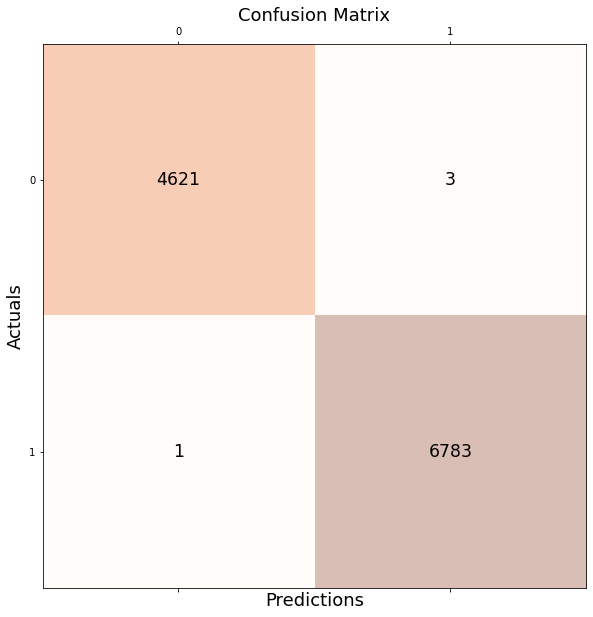

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

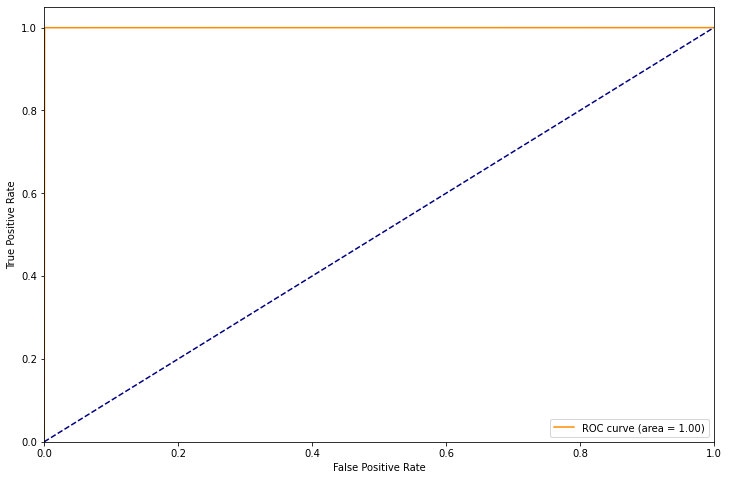

In [12]:
plt.figure(figsize = (12, 8))

fpr, tpr, _ = roc_curve(test_y, testResult)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# 1. Hyperparameter Testing
Determining the best number of principal components using a variation ratio of 0.95 for PCA-related hyperparameters. 

In [13]:
def hyperparameter_testing(p_info, results):
    print('==============================')
    pca = PCA(p_info)
    X_train_pca = pca.fit_transform(train_x)
    X_test_pca = pca.transform(test_x)
      
    rfc.fit(X_train_pca, train_y)
      
    acc = rfc.score(X_test_pca, test_y)
    results.append([acc, pca.n_components_])
    print(acc)
    print(results)
    print()

    testResult = rfc.predict(X_test_pca)
    print(classification_report(test_y, testResult))
    print('n_component = ',pca.n_components_)

In [14]:
results = []
ratio_var = 0.95
hyperparameter_testing(ratio_var, results)

0.9995617110799438
[[0.9995617110799438, 22]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4624
           1       1.00      1.00      1.00      6784

    accuracy                           1.00     11408
   macro avg       1.00      1.00      1.00     11408
weighted avg       1.00      1.00      1.00     11408

n_component =  22


In [15]:
maxacc = 0
chosen_hyperparameter = None
for result in results:
    acc = result[0]
    if maxacc < acc:
        maxacc = acc
        chosen_hyperparameter = result.copy()

## Result of Hyperparameter Testing

In [16]:
for r in results:
    print(f'accuracy: {r[0]} - n components: {r[1]}')

accuracy: 0.9995617110799438 - n components: 22


# 2. Model Validation Testing
Testing is performed using K-Fold validation. The results of this testing include the precision, recall, accuracy, F1-score, ROC curve, and the training time for each iteration of the model.

In [55]:
def convergence_time_test(n_components, roc_list, time_list, acc_list ):
    print('==============================')
    print('n_components =', n_components)
    kfold = KFold(n_splits=10, shuffle=True)
    total_time = 0
    total_acc = 0
    pca = PCA(n_components=n_components)
    i = 1
    
    train_x, train_y, _, _ = load_train_test(df_train, df_test)
    for train_idx, valid_idx in kfold.split(train_x):
        print('\nCurrent KFold = ', i)
        Xtrain, Xvalid = train_x.iloc[train_idx], train_x.iloc[valid_idx]
        Ytrain, Yvalid = train_y.iloc[train_idx], train_y.iloc[valid_idx]
        #scaling
        scaler_kfold = StandardScaler()
        scaler_kfold.fit(Xtrain)
        Xtrain_scaled = scaler_kfold.transform(Xtrain)
        Xvalid_scaled = scaler_kfold.transform(Xvalid)
        # PCA
        time_before_fit_transform_pca = datetime.now()
        X_train_pca = pca.fit_transform(Xtrain_scaled)
        time_after_fit_transform_pca = datetime.now()
        delta_time = time_after_fit_transform_pca - time_before_fit_transform_pca
        
        X_valid_pca = pca.transform(Xvalid_scaled)
        #training RF
        rfc.fit(X_train_pca, Ytrain)
        
        print(time_before_fit_transform_pca)
        print(time_after_fit_transform_pca)
        print('time taken for fit_transform with PCA', delta_time.total_seconds())
        print()
        print('total time =', delta_time.total_seconds())
        
        total_time += delta_time.total_seconds()
        time_list.append(delta_time.total_seconds())
        
        print('Data Train')
        trainResult = rfc.predict(X_train_pca)
        print(rfc.score(X_train_pca, Ytrain))
        print(classification_report(Ytrain, trainResult))
        
        print('Data Valid')
        validResult = rfc.predict(X_valid_pca)
        valid_acc = rfc.score(X_valid_pca, Yvalid)
        total_acc += valid_acc
        acc_list.append(valid_acc)
        print(valid_acc)
        print(classification_report(Yvalid, validResult))
            
        print()
        
        fpr, tpr, _ = roc_curve(Yvalid, validResult)
        roc_auc = auc(fpr, tpr)
        roc_list.append([fpr, tpr, roc_auc])
        print()
        i+=1
        
    avg_time = total_time / 10
    avg_total_val_acc = total_acc / 10
    print('Average time for fit_transform PCA:', avg_time, 'seconds')
    print('Average accuracy of 10 folds :', avg_total_val_acc)

In [56]:
n_components = chosen_hyperparameter[1]
roc_list = []
time_list = []
acc_list = []
convergence_time_test(n_components, roc_list, time_list, acc_list)

n_components = 22

Current KFold =  1
2023-07-02 15:58:20.105599
2023-07-02 15:58:20.554629
time taken for fit_transform with PCA 0.44903

total time = 0.44903
Data Train
0.9999512967247047
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16615
           1       1.00      1.00      1.00     24450

    accuracy                           1.00     41065
   macro avg       1.00      1.00      1.00     41065
weighted avg       1.00      1.00      1.00     41065

Data Valid
0.9995616918693842
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1850
           1       1.00      1.00      1.00      2713

    accuracy                           1.00      4563
   macro avg       1.00      1.00      1.00      4563
weighted avg       1.00      1.00      1.00      4563




Current KFold =  2
2023-07-02 15:58:21.248073
2023-07-02 15:58:21.711614
time taken for fit_transform with PCA 0.463541

to

## Result of Validation Model

In [57]:
for i,acc in enumerate(acc_list):
    print(f'fold {i+1} - accuracy: {acc} - time PCA: {time_list[i]} ')

fold 1 - accuracy: 0.9995616918693842 - time PCA: 0.44903 
fold 2 - accuracy: 0.9997808459346921 - time PCA: 0.463541 
fold 3 - accuracy: 0.9997808459346921 - time PCA: 0.4798 
fold 4 - accuracy: 0.9993425378040762 - time PCA: 0.449974 
fold 5 - accuracy: 0.9989042296734605 - time PCA: 0.421103 
fold 6 - accuracy: 0.9997808459346921 - time PCA: 0.47084 
fold 7 - accuracy: 0.9997808459346921 - time PCA: 0.499742 
fold 8 - accuracy: 0.9997808459346921 - time PCA: 0.443432 
fold 9 - accuracy: 1.0 - time PCA: 0.410703 
fold 10 - accuracy: 1.0 - time PCA: 0.465355 


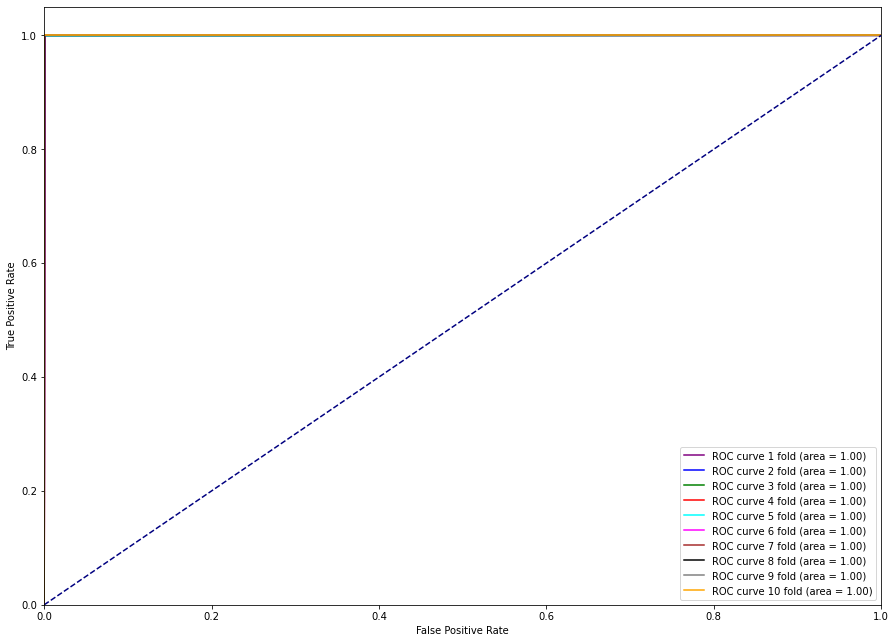

In [60]:
plt.figure(figsize = (15, 11))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'brown', 'black', 'gray', 'orange', 'purple']

for i in range(10):        
    plt.plot(roc_list[i][0], roc_list[i][1], color=colors[i-1], label=f'ROC curve {i+1} fold (area = %0.2f)' % roc_list[i][2])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [61]:
for i,roc in enumerate(roc_list):
    print(f'ROC curve {i+1} fold (area = {roc[2]})')

ROC curve 1 fold (area = 0.9994594594594595)
ROC curve 2 fold (area = 0.9998167155425219)
ROC curve 3 fold (area = 0.999809885931559)
ROC curve 4 fold (area = 0.9992642094094384)
ROC curve 5 fold (area = 0.9989941413777528)
ROC curve 6 fold (area = 0.9997298757428418)
ROC curve 7 fold (area = 0.9998183139534884)
ROC curve 8 fold (area = 0.9997260273972604)
ROC curve 9 fold (area = 1.0)
ROC curve 10 fold (area = 1.0)
